<a href="https://colab.research.google.com/github/MadhurimaPaul-87/Research_Plan_Makaut/blob/main/Chapter_2_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [3]:
# Load EEG, EMG, EOG data
eeg = np.load("/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/eeg_3400.npy")
emg = np.load("/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/emg_3400.npy")
eog = np.load("/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/eog_3400.npy")

In [4]:
# Normalize data
def normalize(x):
    return (x - np.mean(x)) / (np.std(x) + 1e-8)


In [5]:
eeg = normalize(eeg)
emg = normalize(emg)
eog = normalize(eog)

In [6]:
# Ensure 1D vector
eeg = eeg.flatten()
emg = emg.flatten()
eog = eog.flatten()

In [7]:
# Create noisy EEG
noisy_eeg = eeg + 0.5 * emg + 0.5 * eog

In [8]:
# Reshape for Conv1D: [batch, channel, length]
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

eeg_tensor = torch.tensor(eeg, dtype=torch.float32).view(1, 1, -1).to(device)
noisy_tensor = torch.tensor(noisy_eeg, dtype=torch.float32).view(1, 1, -1).to(device)

In [9]:
# Print the shapes of the tensors to verify the dimensions
print("eeg_tensor shape:", eeg_tensor.shape)
print("noisy_tensor shape:", noisy_tensor.shape)

eeg_tensor shape: torch.Size([1, 1, 1088000])
noisy_tensor shape: torch.Size([1, 1, 1088000])


In [10]:
# Define 1D U-Net used in diffusion model
class UNet1D(nn.Module):
    def __init__(self, channels=64):
        super(UNet1D, self).__init__()
        self.enc1 = nn.Conv1d(1, channels, 3, padding=1)
        self.enc2 = nn.Conv1d(channels, channels * 2, 3, padding=1)
        self.enc3 = nn.Conv1d(channels * 2, channels * 4, 3, padding=1)
        self.dec1 = nn.Conv1d(channels * 4, channels * 2, 3, padding=1)
        self.dec2 = nn.Conv1d(channels * 2, channels, 3, padding=1)
        self.out = nn.Conv1d(channels, 1, 1)

    def forward(self, x):
        e1 = F.relu(self.enc1(x))
        e2 = F.relu(self.enc2(e1))
        e3 = F.relu(self.enc3(e2))
        d1 = F.relu(self.dec1(e3))
        d2 = F.relu(self.dec2(d1 + e2))  # Skip connection
        out = self.out(d2 + e1)
        return out

In [11]:
# Diffusion parameters
timesteps = 100
betas = torch.linspace(1e-4, 0.02, timesteps).to(device)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)


In [12]:
# Sampling function
def sample(model, x, timesteps=100):
    x_t = x.clone()
    for t in reversed(range(timesteps)):
        alpha_t = alphas_cumprod[t]
        noise_pred = model(x_t)
        x_t = (x_t - (1 - alpha_t).sqrt() * noise_pred) / alpha_t.sqrt()
        if t > 0:
            noise = torch.randn_like(x_t)
            x_t += (1 - alpha_t).sqrt() * noise
    return x_t

In [13]:
# Train simplified diffusion model
model = UNet1D().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [14]:
# Training loop
for epoch in tqdm(range(20)):
    t = torch.randint(0, timesteps, (1,)).long().to(device)
    alpha_t = alphas_cumprod[t].view(1, 1, 1)
    noise = torch.randn_like(eeg_tensor)
    x_t = alpha_t.sqrt() * eeg_tensor + (1 - alpha_t).sqrt() * noise
    pred_noise = model(x_t)
    loss = loss_fn(pred_noise, noise)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


In [19]:
def sample(model, x, timesteps=100):
    x_t = x.clone()
    for t in reversed(range(timesteps)):
        t_tensor = torch.tensor([t], dtype=torch.long, device=x.device)
        alpha_t = alphas_cumprod[t].to(x.device)
        noise_pred = model(x_t)
        x_t = (x_t - (1 - alpha_t).sqrt() * noise_pred) / alpha_t.sqrt()
        if t > 0:
            noise = torch.randn_like(x_t)
            x_t += (1 - alpha_t).sqrt() * noise
    return x_t

# Then call with CPU model and tensor
model_cpu = model.to('cpu')
noisy_tensor_cpu = noisy_tensor.to('cpu')

with torch.no_grad():
    denoised = sample(model_cpu, noisy_tensor_cpu, timesteps=100).detach().numpy().squeeze()


Clean EEG stats: -7.186889898258368 7.612314162845761 1.6274563396269943e-17
Noisy EEG stats: -14.069437559580392 13.869061051740056 1.1337336298525129e-17
Denoised EEG stats: -2198981000.0 305492200.0 -95944760.0


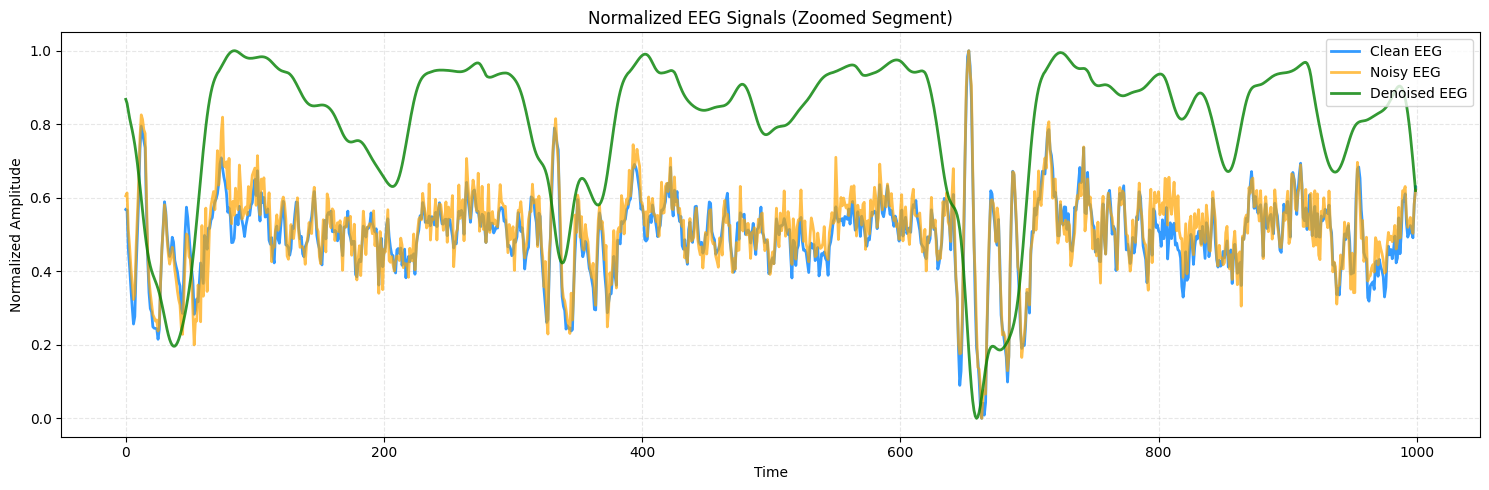

In [25]:
# FIX: Check data integrity and plot range – ensure EEG signals are not constant

# Print min, max, mean to verify variation in signals
print("Clean EEG stats:", eeg.min(), eeg.max(), eeg.mean())
print("Noisy EEG stats:", noisy_eeg.min(), noisy_eeg.max(), noisy_eeg.mean())
print("Denoised EEG stats:", denoised.min(), denoised.max(), denoised.mean())

# Plot a zoomed-in and normalized version for all signals
segment = slice(0, 1000)

eeg_segment = eeg.squeeze()[segment]
noisy_segment = noisy_eeg.squeeze()[segment]
denoised_segment = denoised[segment]

# Normalize for better visual comparison
def rescale(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

eeg_segment = rescale(eeg_segment)
noisy_segment = rescale(noisy_segment)
denoised_segment = rescale(denoised_segment)

plt.figure(figsize=(15, 5))
plt.plot(eeg_segment, label="Clean EEG", color='dodgerblue', linewidth=2.0, alpha=0.9)
plt.plot(noisy_segment, label="Noisy EEG", color='orange', linewidth=2.0, alpha=0.7)
plt.plot(denoised_segment, label="Denoised EEG", color='green', linewidth=2.0, alpha=0.8)
plt.legend(loc="upper right")
plt.title("Normalized EEG Signals (Zoomed Segment)")
plt.xlabel("Time")
plt.ylabel("Normalized Amplitude")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

